# Preparation

In [12]:
import os
import numpy as np
import MyDL
from MyDL import nn as nn
import MyDL.optimizer as optim
import MyDL.data as data

In [13]:
import fashion_mnist.utils.mnist_reader as mnist_reader
X_train, y_train = mnist_reader.load_mnist('fashion_mnist/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('fashion_mnist/data/fashion', kind='t10k')
X_train_mytensor = MyDL.MyTensor(X_train, requires_grad=False)
X_test_mytensor = MyDL.MyTensor(X_test, requires_grad=False)
y_train_mytensor = MyDL.MyTensor(y_train, requires_grad=False)
y_test_mytensor = MyDL.MyTensor(y_test, requires_grad=False)

train_data = data.Dataset(X_train_mytensor, y_train_mytensor)
test_data = data.Dataset(X_test_mytensor, y_test_mytensor)

# Define the model

In [14]:
class MLP3(nn.NeuralNetwork):
    def __init__(self, hidden_size1=100, hidden_size2=10, activation='relu'):
        super().__init__()
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.activ_func = activation
        self.fc1 = nn.Linear(784, hidden_size1, initialize='random')
        self.params += self.fc1.params
        self.fc2 = nn.Linear(hidden_size1, hidden_size2, initialize='random')
        self.params += self.fc2.params
        self.fc3 = nn.Linear(hidden_size2, 10, initialize='random')
        self.params += self.fc3.params
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError('Unknown activation function')
        self.softmax = nn.Softmax()
        self.BN1 = nn.BatchNorm1d()
        self.BN2 = nn.BatchNorm1d()
        self.BN3 = nn.BatchNorm1d()
        self.params += self.BN1.params
        self.params += self.BN2.params
        self.params += self.BN3.params
    def forward(self, x):
        x = self.BN1(x)
        x = self.fc1(x)
        x = self.BN2(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.BN3(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

# Training the best-performing model on whole training data

### Show best model

In [15]:
best_model_name = 'MLP3_(100,10)_tanh_L2-0.0_lr-0.1'
print(f'Best model: {best_model_name}')
with np.load(os.path.join('results', f'{best_model_name}.npz')) as result:
    train_loss = result['train_loss_epoch']
    val_loss = result['val_loss_epoch']
    train_acc = result['train_acc_epoch']
    val_acc = result['val_acc_epoch']
print(f'Train loss: {train_loss[-1]:.3}  Val loss: {val_loss[-1]:.3}  Train acc: {train_acc[-1]:.3}  Val acc: {val_acc[-1]:.3}')

Best model: MLP3_(100,10)_tanh_L2-0.0_lr-0.1
Train loss: 0.385  Val loss: 0.424  Train acc: 0.864  Val acc: 0.851


## Set hyperparameters and train the model

In [23]:
# Hyperparameters below can be changed, while current values may be the best ones
continue_if_exists = True
num_epochs =  15
lambda_L2 = 0.0001
hidden_size1 = 100
hidden_size2 = 10
batch_size = 256
lr = 0.1
activ_func = 'tanh'
model = MLP3(hidden_size1, hidden_size2, activation=activ_func)
model_name = 'MLP3_({},{})_{}_L2-{}_lr-{}'.format(hidden_size1, hidden_size2, activ_func, lambda_L2, lr)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.params, lr=lr, decay_rate=0.2)
result = MyDL.train(model, criterion, optimizer, train_data, test_data, num_epochs, batch_size, lambda_L2=lambda_L2, model_path='final_model_params', result_path='final_results', continue_if_exists=continue_if_exists, calc_val_loss_every_iteration=False)
print(result.keys())
if not (not continue_if_exists and result['continued_train']):    
    MyDL.save_result(**result, path='final_results')

Epoch 1/15. Training Loss:   0.578 	 Accuracy: 0.801
            Validation Loss: 0.540 	 Accuracy: 0.824
Epoch 2/15. Training Loss:   0.464 	 Accuracy: 0.835
            Validation Loss: 0.546 	 Accuracy: 0.828
Epoch 3/15. Training Loss:   0.452 	 Accuracy: 0.841
            Validation Loss: 0.566 	 Accuracy: 0.821
Epoch 4/15. Training Loss:   0.444 	 Accuracy: 0.844
            Validation Loss: 0.543 	 Accuracy: 0.828
Epoch 5/15. Training Loss:   0.442 	 Accuracy: 0.843
            Validation Loss: 0.539 	 Accuracy: 0.821
Epoch 6/15. Training Loss:   0.438 	 Accuracy: 0.844
            Validation Loss: 0.517 	 Accuracy: 0.831
Epoch 7/15. Training Loss:   0.436 	 Accuracy: 0.845
            Validation Loss: 0.513 	 Accuracy: 0.828
Epoch 8/15. Training Loss:   0.437 	 Accuracy: 0.847
            Validation Loss: 0.504 	 Accuracy: 0.834
Epoch 9/15. Training Loss:   0.433 	 Accuracy: 0.849
            Validation Loss: 0.496 	 Accuracy: 0.832
Epoch 10/15. Training Loss:   0.432 	 Accuracy

## Plotting the loss curve

In [62]:
# Plotting the loss curve
import os
import matplotlib.pyplot as plt
best_model_name = 'MLP3_(100,10)_tanh_L2-0.0_lr-0.1'
result = np.load(os.path.join('final_results', f'{best_model_name}.npz'))
x1 = np.arange(0, len(result['train_loss_iter']))
train_loss = result['train_loss_iter']
train_acc = result['train_acc_iter']


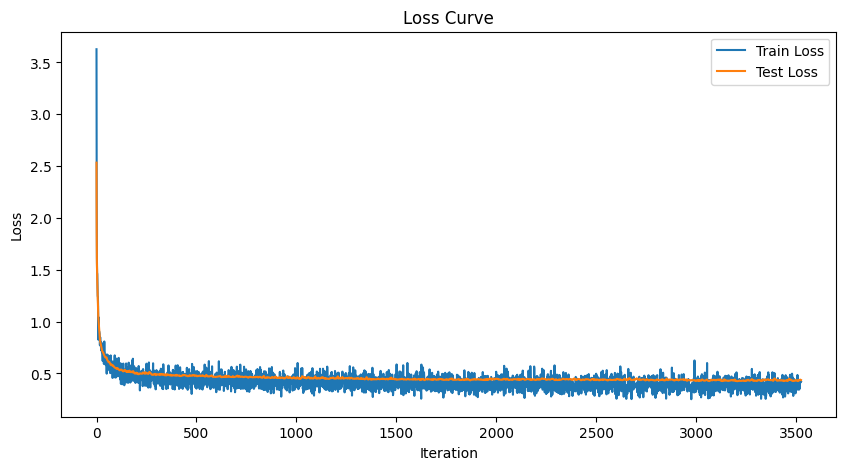

<Figure size 640x480 with 0 Axes>

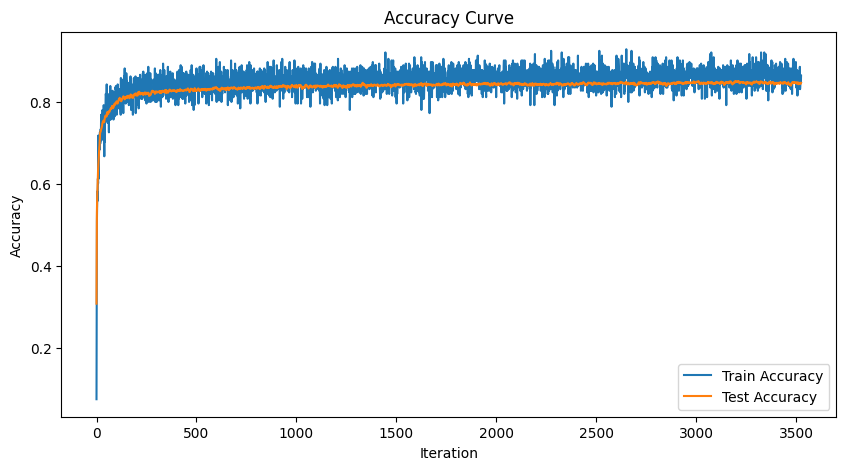

<Figure size 640x480 with 0 Axes>

In [63]:
if not result['no_missing_val_loss_iter']:
    end_point = result['batch_size_till_iter'].T[1]
    batch_size = result['batch_size_till_iter'].T[0]
    iter_per_epoch = 60000 // (batch_size[0]+1)
    start_point = iter_per_epoch
    x2 = np.array([])
    for i in range(len(end_point)):        
        iter_per_epoch = 60000 // batch_size[i]
        x2 = np.concatenate((x2, np.arange(start_point, end_point[i], iter_per_epoch)))
        start_point = end_point[i] + iter_per_epoch
    val_loss = result['val_loss_epoch']
    val_acc = result['val_acc_epoch']
else:
    x2 = x1
    val_loss = result['val_loss_iter']
    val_acc = result['val_acc_iter']
plt.figure(figsize=(10, 5))
plt.plot(x1, train_loss, label='Train Loss')
plt.plot(x2, val_loss, label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()
plt.savefig('final_results/loss_curve.png')

# Plotting the accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(x1, train_acc, label='Train Accuracy')
plt.plot(x2, val_acc, label='Test Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()
plt.savefig('final_results/accuracy_curve.png')

## Visualizing model parameters

In [69]:
model = MLP3(hidden_size1=100, hidden_size2=10, activation='tanh')
best_model_name = 'MLP3_(100,10)_tanh_L2-0.0001_lr-0.1'
model.load(os.path.join('final_model_params', f'{best_model_name}.npz'))

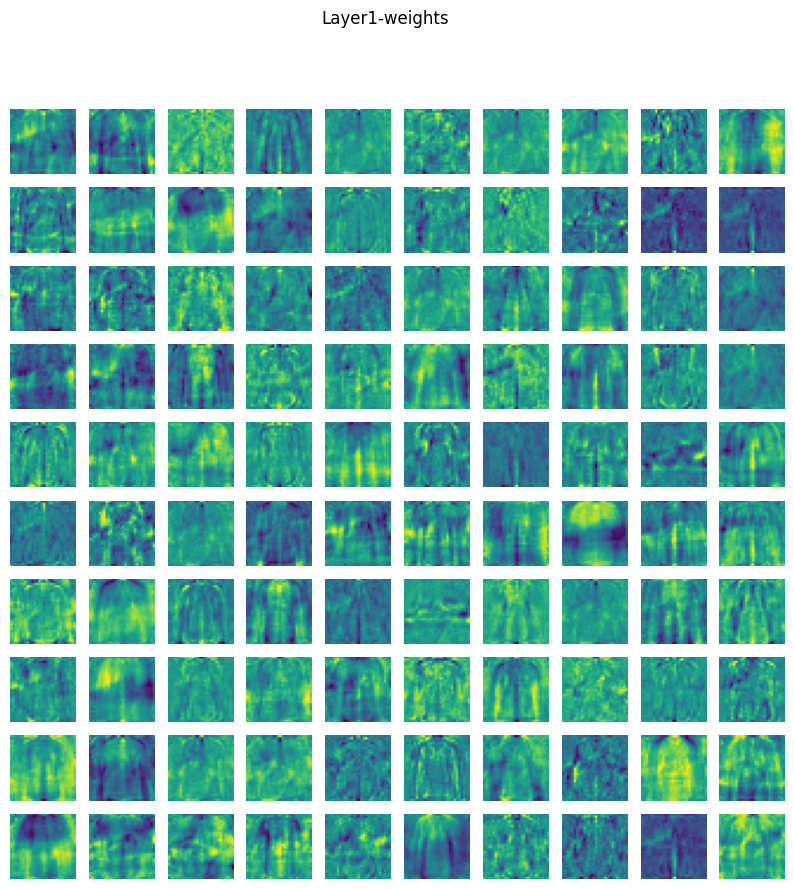

<Figure size 640x480 with 0 Axes>

In [70]:
import matplotlib.pyplot as plt
# Visualizing the first layer
param_name, param = ('Layer1-weights', model.params[0])
param = param.data
reshaped = param.T.reshape(-1, 28, 28)
fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for i in range(reshaped.shape[0]):
    axs[i//10, i%10].imshow(reshaped[i], cmap='viridis')
    axs[i//10, i%10].axis('off')
plt.suptitle(param_name)
plt.show()
plt.savefig(f'final_results/{param_name}.png')


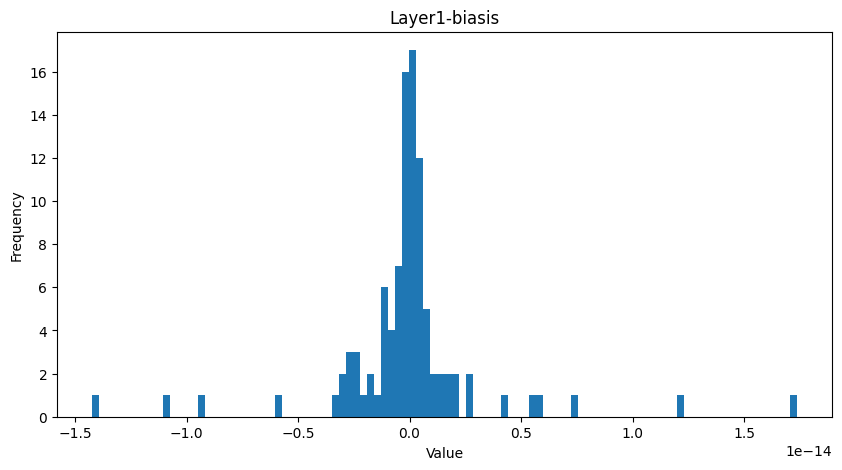

<Figure size 640x480 with 0 Axes>

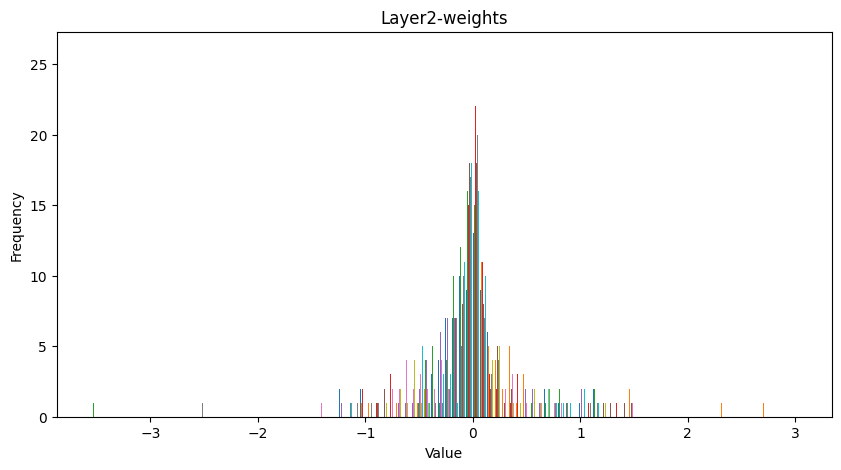

<Figure size 640x480 with 0 Axes>

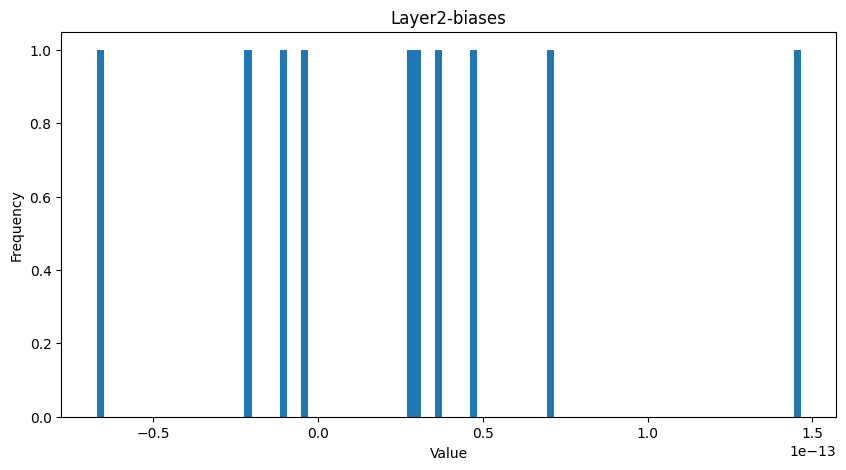

<Figure size 640x480 with 0 Axes>

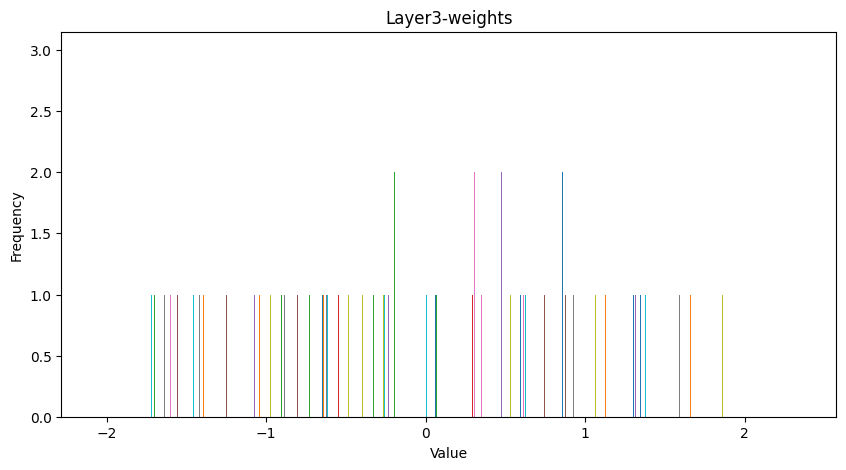

<Figure size 640x480 with 0 Axes>

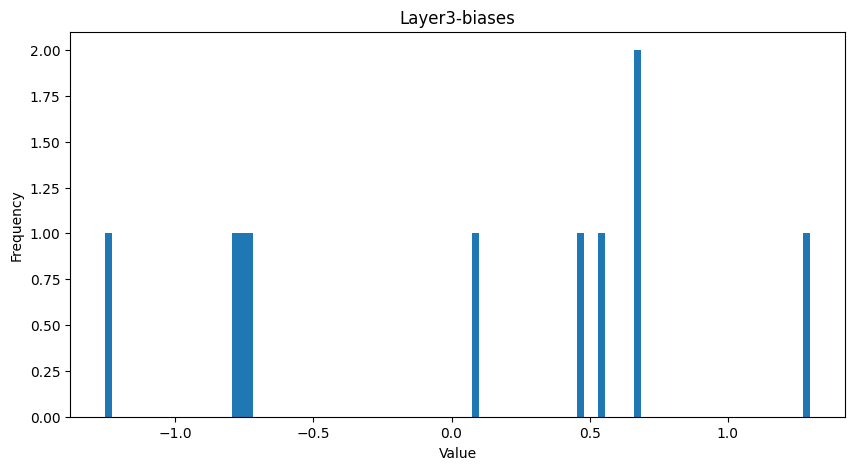

<Figure size 640x480 with 0 Axes>

In [71]:

# visualizing the after layers
for param_name, param in zip(['Layer1-biasis', 'Layer2-weights', 'Layer2-biases', 'Layer3-weights', 'Layer3-biases'] ,model.params[1:]):
    param = param.data
    plt.figure(figsize=(10, 5))
    plt.title(param_name)
    plt.hist(param, bins=100)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()
    plt.savefig(f'final_results/{param_name}.png')

